In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

import pandas_datareader.data as web
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

- 10 and 2 year spread - T10Y2Y
- Unemployment rate - UNRATE
- Change in Inventory - CBIC1
- New Housing Permits - PERMIT
- Housing prices - USSTHPI


In [30]:
Predictors=web.DataReader(["T10Y2Y", "UNRATE", "CBIC1", "PERMIT","USSTHPI", "SLRTTO01USQ661S"], "fred", "1977-01-01", "2025-12-31")

Predictors1 = Predictors.resample('QS').mean()
Predictors1.columns = ["YIELD", "UNRATE", "C_INV", "PERMIT", "HOUSE", "RETAIL"]
Predictors1['C_HOUSE'] =  (Predictors1['HOUSE']/Predictors1['HOUSE'].shift(4))-1
Predictors1['C_RETAIL'] = (Predictors1['RETAIL']/Predictors1['RETAIL'].shift(4))-1
Predictors1 = Predictors1.dropna()

Predictors2 = Predictors1.drop(['HOUSE', 'RETAIL'], axis=1)

In [31]:
#Historical Recession Dates
Recession = web.DataReader(["USRECQ"], "fred", "1977-01-01", "2025-12-31")

#RecessionDates[RecessionDates["USRECQ"]==1]

In [32]:
alldata = Predictors2.shift(1).dropna()
alldata['Recession'] = Recession["USRECQ"]

In [33]:
X = alldata.drop(['Recession'], axis=1).copy()
y = alldata['Recession'].copy()

In [34]:
y.mean() 

#unconditional probability of a recession. In other words, from 1977-2018, a recession occured in 11.18% of all quarters from the date range

np.float64(0.11180124223602485)

Logistic Regression Model

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25, random_state=123)

len(X_train), len(X_test), len(y_train), len(y_test) #number of observations

(120, 41, 120, 41)

In [36]:
model = LogisticRegression()
model.fit(X_train, y_train) #fitting with the training data
yhat_logistic = model.predict(X_test) #predict y values(0 or 1 for a recession) using the test data

mean_squared_error(y_test, yhat_logistic)

#1-mse for the accuracy of the model

0.0975609756097561

Text(0, 0.5, 'C_RETAIL')

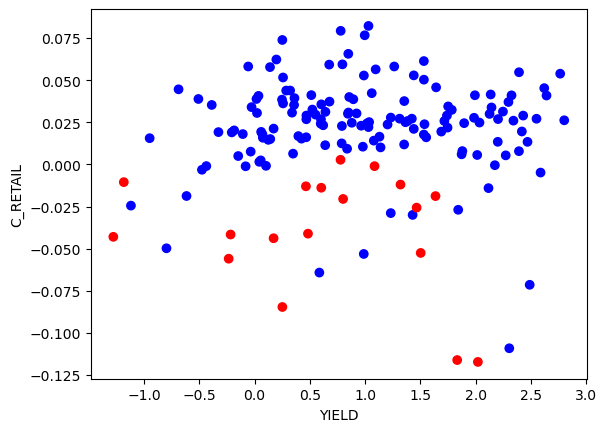

In [37]:
c=np.array(["k"]*len(y))
for i in range(len(y)):
    if y[i]==1:
        c[i]="r" #red if recession
    else:
        c[i]="b" #blue if non-recession
plt.scatter(X["YIELD"],X["C_RETAIL"],color=c)
plt.xlabel("YIELD")
plt.ylabel("C_RETAIL")

KNN Model

In [38]:
model1 = KNeighborsClassifier(n_neighbors=3)
model1.fit(X_train, y_train)
yhat_train = model1.predict(X_train) 
yhat_test = model1.predict(X_test)

In [39]:
accuracy_score(y_train, yhat_train)

0.9166666666666666

In [40]:
accuracy_score(y_test, yhat_test)

0.8780487804878049

In [41]:
#Changing Neighbors 1 through 30 to see which are best
maxneighbors = 30
trainscore=[]
testscore=[]
for i in range(1, maxneighbors+1):
    model2=KNeighborsClassifier(n_neighbors=i)
    model2.fit(X_train, y_train)
    yhat2_train = model2.predict(X_train) 
    yhat2_test = model2.predict(X_test)
    trainscore.append(accuracy_score(y_train, yhat2_train))
    testscore.append(accuracy_score(y_test, yhat2_test))
trainscore_np = np.array(trainscore)
testscore_np = np.array(testscore)

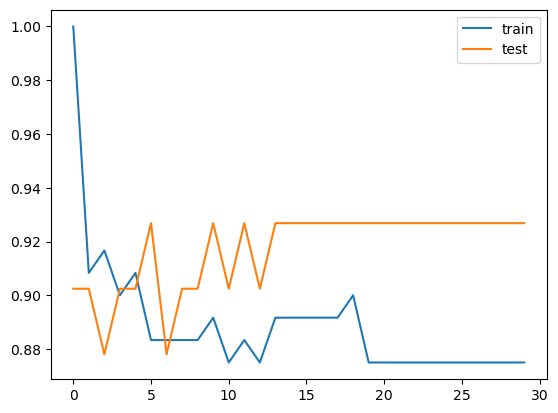

In [42]:
plt.plot(trainscore_np, label='train')
plt.plot(testscore_np, label='test')
plt.legend()

#optimal once test plateaus around 14

Decision Tree Model

In [43]:
model3 = DecisionTreeClassifier()
model3.fit(X_train, y_train)
yhat3_train = model3.predict(X_train)
yhat3_test = model3.predict(X_test)

accuracy_score(y_test, yhat3_test)

0.9512195121951219

In [44]:
#building the tree
export_graphviz(model3, out_file="tree.dot", class_names=["Expansion", "Recession"], feature_names=X.columns, impurity=False, filled=True)

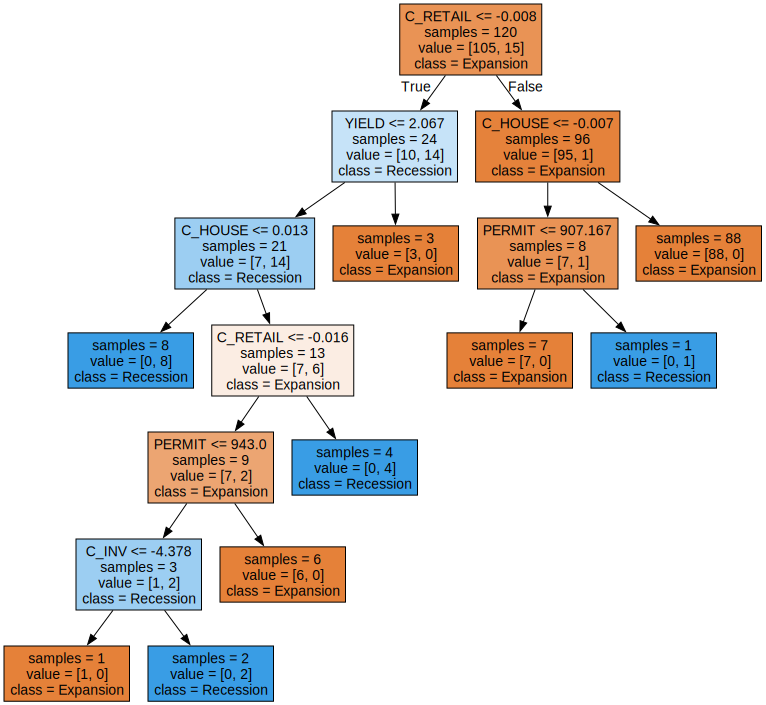

In [45]:
with open("tree.dot") as file:
    decision_tree=file.read()
graphviz.Source(decision_tree)

([<matplotlib.axis.YTick at 0x22236c12710>,
 [Text(0, 0, 'YIELD'),
  Text(0, 1, 'UNRATE'),
  Text(0, 2, 'C_INV'),
  Text(0, 3, 'PERMIT'),
  Text(0, 4, 'C_HOUSE'),
  Text(0, 5, 'C_RETAIL')])

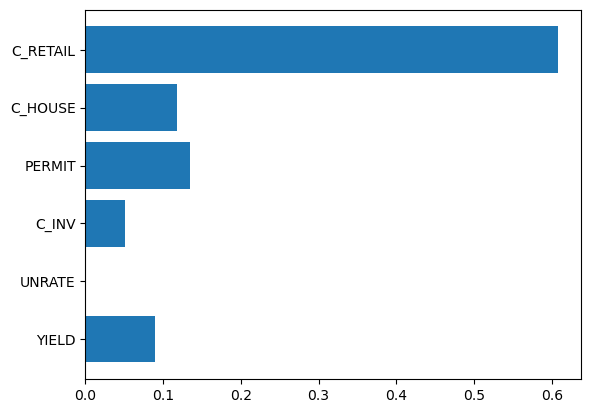

In [46]:
# Feature Importance
plt.barh(range(len(X_train.columns)),model3.feature_importances_)
plt.yticks(range(len(X_train.columns)),X_train.columns)

Random Forests Model

In [64]:
model4 = RandomForestClassifier(n_estimators=20) #number of trees
model4.fit(X_train, y_train)
yhat4_train = model4.predict(X_train) 
yhat4_test = model4.predict(X_test)

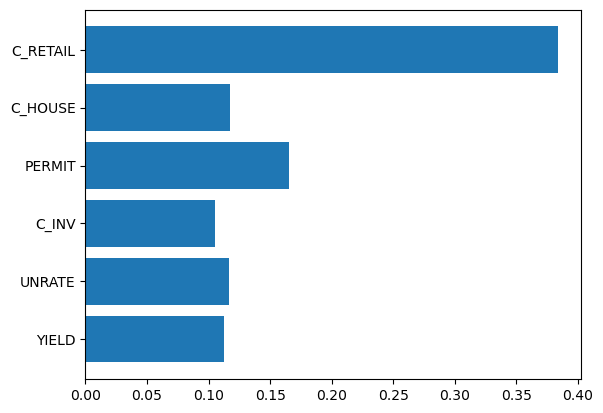

In [66]:
# Feature Importance
plt.barh(range(len(X_train.columns)), model4.feature_importances_)
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.show()